In [1]:
# Loading required dependencies
import pandas as pd
from transformers import BertForPreTraining, BertTokenizer, AutoTokenizer, AutoModelForSequenceClassification, DistilBertConfig,BertForSequenceClassification, AutoModelForSequenceClassification, AutoTokenizer, get_scheduler
import re
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score, roc_curve,confusion_matrix
import optuna
import os
from nltk.stem import PorterStemmer
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from transformers import BertForSequenceClassification
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu' )
data_path = 'full_Data.csv'
#device = torch.device("mps" if torch.backends.mps.is_available() and device != 'cuda' else 'cpu' )
df = pd.read_csv(data_path,index_col= [0])

In [3]:
#Remove na and duplicate
df.drop_duplicates(inplace=True)
df.dropna(inplace = True)

Average number of words in an SMS: 1259.6406191879596


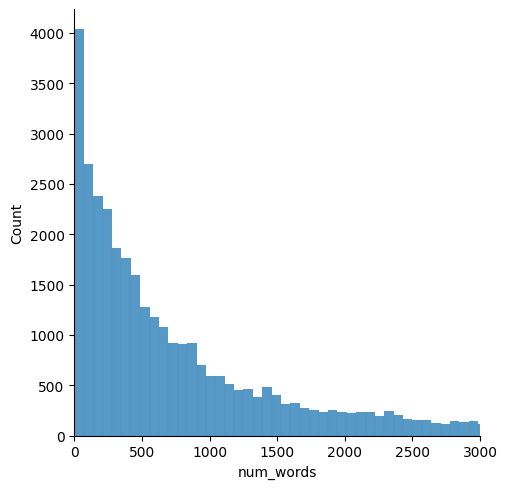

In [4]:
df['num_words'] = df.Text.apply(len)
sns.displot(df.num_words)
plt.xlim(0, 3000)
print("Average number of words in an SMS:",df.num_words.mean())

In [5]:
df.drop(df[df['num_words'] < 8].index,inplace = True)
df = df.reset_index(drop = True)
df.sort_values(by ='num_words',ascending = False) # The longest sms seems to be a news clip, we also want to inspect what is people sening around 1000 words

,Text,Label,num_words
18703,enron : a wake - up call\nthe wall street jour...,ham,228353
18374,"rival to buy enron , top energy trader , after...",ham,178837
18640,fall of a power giant : bailout is unlikely if...,ham,165933
18578,accounting peer review gets more scrutiny\nthe...,ham,141870
18600,enron and dynegy discuss plan to cut price of ...,ham,136478
...,...,...,...
16483,thankyou,ham,8
619,Thank u!,ham,8
3256,My phone,ham,8
270,Thanx...,ham,8


In [6]:
df[df['num_words']< 10000].sort_values('num_words',ascending=False).loc[30233].Text

'attached below is the cpuc \' s proposed decision in the gas industry\nrestructuring proceeding . essentially , it adopts the interim proposal with a\nfew modifications . the cpuc states that they are taking a " cautious "\napproach to deregulation in light of recent market events in both electricity\nand gas , and therefore , rejected the more robust reforms outlined in the\ncomprehensive settlement . the cs was offered by socal gas and supported by\nmany of the settlement parties , including enron and transwestern .\nthe good news is that , with respect to hector road , the maximum volume at\nhector is limited to 50 mmcf / d , similar to the proposal made by the\ncomprehensive settlement . i \' ve included the section from the pd that deals\nwith this issue for your convenience . the full document is also attached .\nexcerpt at at page 50 regarding hector road :\n( 1 ) receipt points / intrastate transmission\nas we have already discussed above , we now judge that intrastate transmi

In [7]:
df.drop(df[df['num_words'] > 10000].index,inplace = True)

In [8]:
df = df.reset_index(drop = True)

In [9]:
model_path=  "prajjwal1/bert-tiny" 
lemma  = WordNetLemmatizer() # 
tokneizer = AutoTokenizer.from_pretrained(model_path,do_lower_case = True)

In [10]:
def text_cleaning(text):
    text = re.sub(r'[^a-zA-Z0-9\s]',' ',text)
    text = re.sub(r'\n','',text )
    text = re.sub(r'\t','',text )
    re.sub(r'\s{2,}', ' ', text)
    stop_words = set(stopwords.words('english'))
    tokens = tokneizer.tokenize(text)
    tokens = [lemma.lemmatize(token) for token in tokens if token not in stop_words]
    text = ' '.join(tokens)
    return text


In [11]:
df_clean = df.copy()

In [12]:
df_clean['Text'] = df['Text'].apply(text_cleaning)
df_clean['Label'] = df['Label'].apply(lambda x: 1 if x == 'spam' else 0)

In [13]:
df_clean

,Text,Label,num_words
0,go ju ##rong point crazy available bug ##is n ...,0,111
1,ok la ##r joking wi ##f u ##i,0,29
2,free entry 2 w ##k ##ly com ##p win fa cup fin...,1,155
3,u dun say early ho ##r u c already say,0,49
4,nah think go u ##f life around though,0,61
...,...,...,...
34639,hello e ##ja ##cula ##te within minute ##pen #...,1,892
34640,hello welcome gig ##ap ##har ##m ##lin ##ne sh...,1,281
34641,got earlier expected wrapped cautiously ##im #...,1,803
34642,ready rock let man rise solitude show u societ...,1,317


In [14]:
def visulize_token(text):
    print(f"Token {tokneizer.tokenize(text)}")
    print(f"Token to ID: {tokneizer.convert_tokens_to_ids(tokneizer.tokenize(text))}")
    print(f"Token to String: {tokneizer.convert_tokens_to_string(tokneizer.tokenize(text))}")

In [15]:
visulize_token(df_clean['Text'][30288])

Token ['audrey', 'robertson', '#', '#', 'tr', '##a', '#', '#', 'ns', '#', '#', 'west', '#', '#', 'er', '##n', 'pipeline', 'company', '#', '#', 'em', '##a', '#', '#', 'il', 'address', 'audrey', 'robertson', 'en', '#', '#', 'ron', 'com', '71', '#', '#', '3', '85', '#', '#', '3', '58', '#', '#', '49', '71', '#', '#', '3', '64', '#', '#', '6', '255', '#', '#', '1', 'fa', '#', '#', 'x', '##a', '#', '#', 'tt', '##a', '#', '#', 'che', '##d', 'dated', 'plane', 'schedule', 'please', 'call', 'question', 'virginia', 'neill', '#', '#', 'nor', '#', '#', 'the', '##r', '#', '#', 'n', 'plain', 'natural', 'gas', 'co', 'omaha', '04', '#', '#', '31', '#', '#', 'tel', '#', '#', 'ep', '#', '#', 'hon', '##e', '402', '39', '#', '#', '8', '70', '#', '#', '7', '#', '#', '1', '#', '#', 'fa', '#', '#', 'x', '402', '39', '#', '#', '8', '75', '#', '#', '59']
Token to ID: [14166, 9923, 1001, 1001, 19817, 2050, 1001, 1001, 24978, 1001, 1001, 2225, 1001, 1001, 9413, 2078, 13117, 2194, 1001, 1001, 7861, 2050, 1001, 10

In [16]:
#Train val test split 80/10/10
train_input,_ = train_test_split(df_clean,test_size=.2)
val_input,test_input = train_test_split(_,test_size=.5)

In [17]:
max_len = 512 #max length support by bert
def mask_input_for_bert(text_df,max_len):
    input_ids = []
    attention_masks = []
    for text in text_df:
        encoded_dict = tokneizer.encode_plus(
            text = text,
            add_special_tokens= True,
            max_length=max_len,
            padding = 'max_length',
            return_attention_mask=True,
            truncation= True
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])
    input_ids = torch.tensor((input_ids))
    attention_masks = torch.tensor(attention_masks)
    return input_ids,attention_masks

In [18]:
df_inp,df_mask = mask_input_for_bert(df_clean['Text'],max_len)

In [19]:
train_inp,train_mask = mask_input_for_bert(train_input['Text'],max_len)
valid_inp,valid_mask = mask_input_for_bert(val_input['Text'],max_len)
test_inp,test_mask = mask_input_for_bert(test_input['Text'],max_len)

In [20]:
train_label = torch.tensor(train_input['Label'].values)
valid_label =torch.tensor(val_input['Label'].values)
test_label = torch.tensor(test_input['Label'].values)

In [21]:
train_dataset = TensorDataset(train_inp, train_mask, train_label)
valid_dataset = TensorDataset(valid_inp, valid_mask, valid_label)
test_dataset = TensorDataset(test_inp, test_mask, test_label)

In [22]:
# Create a data loader
model = AutoModelForSequenceClassification.from_pretrained(model_path)
batch_size = 64
criterion = nn.CrossEntropyLoss()
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initia

In [24]:
# Number of training steps
num_epochs = 50
num_training_steps = num_epochs * len(train_loader)

# Optimizer
# Update 05.2023 - Tring to use Lion optimizer introduced recently
from lion_pytorch import Lion

#optimizer = optim.AdamW(params=model.parameters(), lr=1e-6)
optimizer = Lion(model.parameters(), lr=1e-6, weight_decay=1e-2)
# Set up the learning rate scheduler
lr_scheduler = get_scheduler(name="linear", 
                             optimizer=optimizer, 
                             num_warmup_steps=0, 
                             num_training_steps=num_training_steps)

# Send model to device
model.to(device)

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-1): 2 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [25]:
import evaluate
metric1 = evaluate.load("accuracy")
metric2 = evaluate.load("f1")
metric3 = evaluate.load("recall")


In [26]:
#Freeze top layer of model and change classifer 
for param in model.parameters():
    param.required_grad = False

In [27]:
num_features = model.classifier.in_features

In [28]:
#num_features = model.classifier.in_features

model.classifier = nn.Sequential(
    nn.Dropout(p = 0.25),
    nn.Linear(in_features=num_features,out_features=2,bias = True)
).to(device)



In [65]:
import matplotlib.pyplot as plt


In [34]:
train_loss = 0
train_losses = []
valid_losses = []

for epoch in range(num_epochs):
    model.train()
    for batch in train_loader:
        inputs = batch[0].to(device)
        attention_masks = batch[1].to(device)
        labels = batch[2].to(device)
        optimizer.zero_grad()
        outputs = model(inputs, attention_mask=attention_masks)[0]
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        lr_scheduler.step()
        train_loss += loss.item()
    train_loss /= len(train_dataset)
    train_losses.append(train_loss / len(train_loader))  # Calculate average train loss per epoch
    
    logits_alls = []
    predicted_prob_all = []
    predictions_all = []
    y_true = []
    y_pred = []
    valid_loss = 0
    valid_acc = 0
    model.eval()
    with torch.no_grad():
        for batch in valid_loader:
            inputs = batch[0].to(device)
            attention_masks = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(inputs, attention_mask=attention_masks)[0]
            loss = criterion(outputs, labels)
            valid_loss += loss.item()
            logits = outputs.logit
            logits_alls.append(logits)
            _, preds = torch.max(outputs, dim=1)
            valid_acc += torch.sum(preds == labels).item()
            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()
            metric1.add_batch(predictions=preds, references=batch[2])
            metric2.add_batch(predictions=preds, references=batch[2])
            metric3.add_batch(predictions=preds, references=batch[2])
        
        valid_loss /= len(valid_dataset)
        valid_acc /= len(valid_dataset)
        valid_losses.append(valid_loss)
        
    print(f"Epoch {epoch+1}, Train Loss: {train_loss}, Valid Loss: {valid_loss}, Valid Acc: {valid_acc}, Accuracy: {metric1.compute()}, F1: {metric2.compute()}, Recall: {metric3.compute()}")


Epoch 1, Train Loss: 0.3565599779997553, Valid Loss: 0.0046843787866018664, Valid Acc: 0.9041570438799076, Accuracy: {'accuracy': 0.9041570438799076}, F1: {'f1': 0.8873812754409769}, Recall: {'recall': 0.8977350720658888}
Epoch 2, Train Loss: 0.654978871929206, Valid Loss: 0.003936202448145347, Valid Acc: 0.9174364896073903, Accuracy: {'accuracy': 0.9174364896073903}, F1: {'f1': 0.9017857142857142}, Recall: {'recall': 0.9011667810569663}
Epoch 3, Train Loss: 0.9064466900745844, Valid Loss: 0.0034161973400493144, Valid Acc: 0.9292725173210161, Accuracy: {'accuracy': 0.9292725173210161}, F1: {'f1': 0.9170896785109983}, Recall: {'recall': 0.9299931365820179}
Epoch 4, Train Loss: 1.1220821557815448, Valid Loss: 0.002964216518897658, Valid Acc: 0.9399538106235565, Accuracy: {'accuracy': 0.9399538106235565}, F1: {'f1': 0.9290102389078498}, Recall: {'recall': 0.9341111873713109}
Epoch 5, Train Loss: 1.311237151326809, Valid Loss: 0.0026118824071321833, Valid Acc: 0.9477482678983834, Accuracy:

In [36]:
test_loss = 0
test_acc = 0
y_true = []
y_pred = []

with torch.no_grad():
        model.eval()
        for batch in test_loader:
            inputs = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            outputs = model(inputs, attention_mask=attention_mask)[0]
            loss = criterion(outputs,labels)
            valid_loss+=loss.item()
            logits = outputs.logit
            logits_alls.append(logits)
            _,preds = torch.max(outputs,dim = 1)
            valid_acc += torch.sum(preds == labels).item()
            y_true += labels.cpu().numpy().tolist()
            y_pred += preds.cpu().numpy().tolist()
            metric1.add_batch(predictions=preds, references=batch[2])
            metric2.add_batch(predictions=preds, references=batch[2])
            metric3.add_batch(predictions=preds, references=batch[2])
        test_loss /= len(test_dataset)
        test_acc /= len(test_dataset)
        print(f"Test loss {test_loss}, Test Acc: {test_acc}, Accuracy {metric1.compute()}, F1 {metric2.compute()} Recall {metric3.compute()}")
        

Test loss 0.0, Test Acc: 0.0, Accuracy {'accuracy': 0.9714285714285714}, F1 {'f1': 0.9657320872274143} Recall {'recall': 0.9680777238029147}


In [37]:
#Save model and parameterfor loading at backend
torch.save(model,'model_presentation.pth')

In [38]:
#TEST BY INPUTING RAW STRING

import torch
import transformers
device
model = torch.load('model_presentation.pth').to(device)

In [39]:
def test_model(text):
    inputs_input_ids = torch.tensor(tokneizer.encode(text, add_special_tokens=True)).unsqueeze(0).to(device)
    logits = model(inputs_input_ids)[0].to(device)
    # Convert the logits to probabilities
    probs = torch.softmax(logits, dim=1).squeeze(0)
    # Get the predicted label and its probability
    pred_label = torch.argmax(probs).item()
    pred_prob = probs[pred_label]
    return pred_label,pred_prob.item()


In [86]:
text ="URGENT: Your bank account has been compromised! Click the link below to verify your account details immediately, or your funds may be at risk."
text2 = 'Hey Mark, long time no see! I heard you recently onduct of tax claim for last financial year, call below number now to avoid penalty,'
text10= 'Hi Alex, john gave me this number for the event tomorrow, can i call you and discuss some detail when you are free? Thanks!'
text11 = 'Hey josh, I knew someone yesterday saying he got some way to grab some quick cash, i know you are kinda short on money so count you in?'
text12= 'Hi Josh, need some quick cash? callmoved to the city. How about we grab dinner this weekend and catch up? I know a great restaurant downtown. Let me know if youre interested. Cheers, Lisa.'
text3 = "Attention: Your Amazon account has been temporarily suspended due to suspicious activity. To reactivate your account and secure your personal information, please click the link below and provide your login credentials and updated payment details within 24 hours. Failure to comply may result in permanent account termination."
text4 = 'reset your password now!, your netflex account has been compromised'
text5 = 'wanna earn some fast cash? click the link below and find out more, totally legal and legit, no tricks just win'
text6 = 'Call me when you got home okay? Hope you had a good night'
text7 = 'Hello, your shipment from UPS will arrive today. Click here to track your package'
text8 = '“Your Wells Fargo account has been locked for suspicious activity. Please log in here and verify your account.”'
text9 = 'This is ATO trying to reach you out regarding a msc us today, no tricks, just money'

In [85]:
label,probability = test_model(text7)#Testing model using various of new strings
print(f"This string is idenfity as {'spam' if label == 1 else 'ham'} with probability of {round(probability,5)}")

This string is idenfity as spam with probability of 0.73195


### Ideas for futrue improvement
- Retrain model using newly seen spam sms. As this might related to more recent topic, ie COVID, loan interest
- Build a ETL pipeline to automatelly apply preprocessing to raw data, feed clean data to model directly for training (Archiecture: AWS - MAGE - SAGEMAKER or equvient)
- tring different 